<a href="https://colab.research.google.com/github/bongkyunSON/Project/blob/main/dacon_bike_221212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Only for colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

In [2]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
import holidays
from prophet.plot import add_changepoints_to_plot
import datetime as dt
from plotnine import *


import itertools
import numpy as np
import pandas as pd
import os
import holidays
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Project/data/bike/'
train = pd.read_csv(base_path + 'train.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')
save_path = '/content/drive/MyDrive/Colab Notebooks/Project/dacon/bike/submission/'

In [4]:
train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')

In [5]:
regions = ['광진구', '동대문구', '성동구', '중랑구']

In [6]:
metric = 'mae'

In [7]:
for region in regions():
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1
    LT= Q1-1.5*IQR
    HT= Q3+1.5*IQR
    df['outlier']=np.where(((df['y']<LT)|(df['y']>HT)),'yes','no')
    df = df.loc[(df['outlier'] =='yes'), 'y'] = None
    df['y'] = df.y.interpolate(method='linear')
    print(df)

TypeError: ignored

### EDA_code

In [ ]:
model = Prophet(
    changepoint_prior_scale=0.4,
    # weekly_seasonality=10,
    # yearly_seasonality=20,
    # daily_seasonality=10
    seasonality_mode='multiplicative',

    
    
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=7)

In [ ]:
for region in regions:
    model = Prophet(
    changepoint_prior_scale=0.4,
    # weekly_seasonality=10,
    # yearly_seasonality=20,
    # daily_seasonality=10
    seasonality_mode='multiplicative',
    
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=7)
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]
    model.fit(df)
    future = model.make_future_dataframe(periods=365, freq='D')
    forecast = model.predict(future)

In [ ]:
pd.concat((holiday, summer))

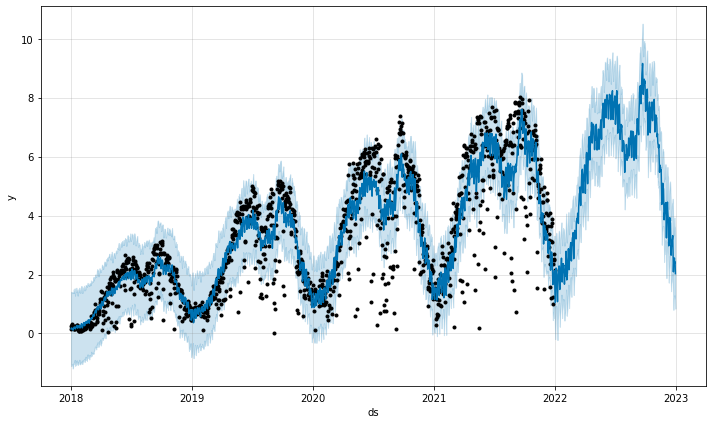

In [ ]:
fig1 = model.plot(forecast)

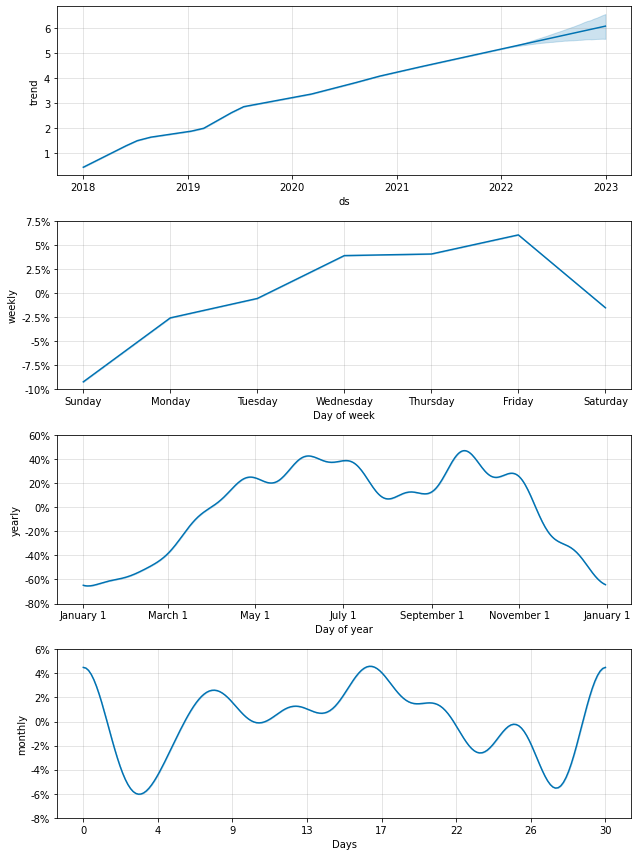

In [ ]:
fig2 = model.plot_components(forecast)
#일요일 데이터는 확실히 낮고, 토요일 데이터도 많이 줄어든다
#월 화 수 목 금 점차 데이터가 올라간다

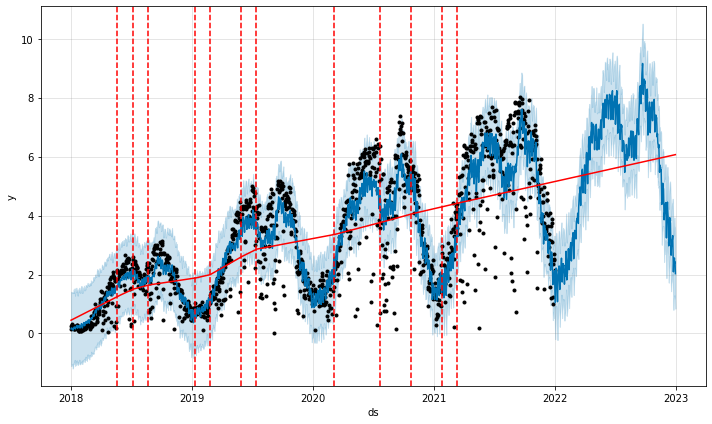

In [ ]:
fig3 = model.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), model, forecast)

### 연습코드

In [ ]:
def predict(train, column):
    model = Prophet()
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model.fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

for region in regions:
    submission[region] = predict(train, region)

submission

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(4, 1, figsize=(20, 28))
regions = ['광진구', '동대문구', '성동구', '중랑구']
for i in range(4):
    sns.lineplot(train['일시'], train[regions[i]], ci=None, ax=ax[i])
plt.show()

In [ ]:
model = Prophet()
df = pd.DataFrame()
df['ds'] = train['일시']
df['y'] = train['동대문구']
model.fit(df)

df_cv = cross_validation(model,
                         initial='730 days',
                         period='30 days',
                         horizon='334 days',
                         parallel="processes")
df_cv

In [ ]:
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p

In [ ]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

In [ ]:
"""
Hyper-parameter Tuning with Prophet + GridSearchCV
Tutorial
"""

param_grid = {
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train['광진구']
    model.fit(df)  # Fit model with given params
    df_cv = cross_validation(model, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results

In [ ]:
tuning_results = tuning_results.sort_values(by=['mae']).reset_index(drop=True)
tuning_results.iloc[0, :-1].to_dict()
# final_param = tuning_results.iloc[0, :-1].to_dict()

In [ ]:
forecast.loc[1461:, ['ds', 'yhat']]

### 정리 code

In [ ]:
def predict(train, column):
    """
    Basic prediction model
    """
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model = Prophet().fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

In [12]:
def predict2(train: pd.DataFrame, region: str, param_grid: dict):
    """
    Upgraded prediction model with hyper-parameter tuning
    """
    # Make time series dataframe for each region
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]


    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    maes = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        summer = ['2018-06-01', '2018-08-31', '2019-06-01', '2019-08-31', '2020-06-01', '2020-08-31', '2021-06-01', '2021-08-31']
        model = Prophet(changepoints=summer, 
                        weekly_seasonality=True,
                        yearly_seasonality=True,
                        **params)
        model.fit(df)  # Fit model with given params
        df_cv = cross_validation(model, horizon='365 days', parallel="processes")
        df_p = performance_metrics(df_cv)
        maes.append(df_p['mae'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mae'] = maes

    # Sorted by rmes values
    tuning_results = tuning_results.sort_values(by=['mae'])

    # Pick the optimized(having minimum rmse value) hyper-parameter combination
    final_params = tuning_results.iloc[0, :-1].to_dict()

    # Train the final model with optimized params
    m = Prophet(**final_params).fit(df)
    future = m.make_future_dataframe(periods=334, freq='D')
    forecast = m.predict(future)
    
    # Make the predict column for submission
    return final_params, forecast.loc[1461:, 'yhat'].values

In [9]:
import holidays
#"KR-Holidays"
holiday = pd.DataFrame([])
for date, name in sorted(holidays.KR(years=[2018,2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday' : "KR-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday

,ds,holiday
0,2018-01-01,KR-Holidays
1,2018-02-15,KR-Holidays
2,2018-02-16,KR-Holidays
3,2018-02-17,KR-Holidays
4,2018-03-01,KR-Holidays
...,...,...
67,2021-10-03,KR-Holidays
68,2021-10-04,KR-Holidays
69,2021-10-09,KR-Holidays
70,2021-10-11,KR-Holidays


In [13]:
final_params = []
# Set the candidates of hyper-parameters
param_grid = {
    'holidays' : [holiday],
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale' : [0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
}
for region in regions:
    temp, submission[region] = predict2(train, region, param_grid)
    final_params.append(temp)

ValueError: ignored

In [ ]:
# Print hyper-parameters after tuning
for region, params in zip(regions, final_params):
    print(f"--------------- Hyper-parameters of {region} ---------------")
    print('changepoint_prior_scale : ', params['changepoint_prior_scale'])
    print('seasonality_prior_scale : ', params['seasonality_prior_scale'])
    print('seasonality_mode        : ', params['seasonality_mode'])
    print('holidays_prior_scale  :  ', params['holidays_prior_scale'])
# Check submission file name and define file name
if 'submission_bike.csv' in os.listdir(save_path):
    count = 0
    for name in os.listdir(save_path):
        if 'submission_bike' in name:
            count += 1
    filename = f"submission_bike{count + 1}.csv"
else:
    filename = 'submission_bike.csv'

# Export submission file
submission.to_csv(save_path + filename, index=False)

--------------- Hyper-parameters of 광진구 ---------------
changepoint_prior_scale :  0.001
seasonality_prior_scale :  0.5
seasonality_mode        :  multiplicative
holidays_prior_scale  :   0.1
--------------- Hyper-parameters of 동대문구 ---------------
changepoint_prior_scale :  0.1
seasonality_prior_scale :  5.0
seasonality_mode        :  multiplicative
holidays_prior_scale  :   0.1
--------------- Hyper-parameters of 성동구 ---------------
changepoint_prior_scale :  0.001
seasonality_prior_scale :  0.01
seasonality_mode        :  multiplicative
holidays_prior_scale  :   0.1
--------------- Hyper-parameters of 중랑구 ---------------
changepoint_prior_scale :  0.1
seasonality_prior_scale :  5.0
seasonality_mode        :  multiplicative
holidays_prior_scale  :   15.0
